SECTION 1: SUPERVISED CNN WITH TRANSFER LEARNING
Found 2870 images belonging to 2 classes.
Found 394 images belonging to 2 classes.

 Training samples: 2870
 Test samples: 394
 Classes: {'no_tumor': 0, 'tumor': 1}


Model: "Tumor_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


 Training supervised classifier...
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 572ms/step - accuracy: 0.8941 - loss: 0.3970 - val_accuracy: 0.7081 - val_loss: 0.5464
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 561ms/step - accuracy: 0.9551 - loss: 0.1189 - val_accuracy: 0.7716 - val_loss: 0.4587
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 557ms/step - accuracy: 0.9641 - loss: 0.0971 - val_accuracy: 0.7817 - val_loss: 0.5373
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 557ms/step - accuracy: 0.9728 - loss: 0.0820 - val_accuracy: 0.7843 - val_loss: 0.5145
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 626ms/step - accuracy: 0.9749 - loss: 0.0655 - val_accuracy: 0.8223 - val_loss: 0.4856
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 626ms/step - accuracy: 0.9805 - loss: 0.0551 - val_accuracy: 0.8909 - val_loss: 0.2460
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 555ms/step - accuracy: 0.9854 - loss: 0.0457 - val_accuracy: 0.8706 - val_loss: 0.3927
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 557ms/step - accura

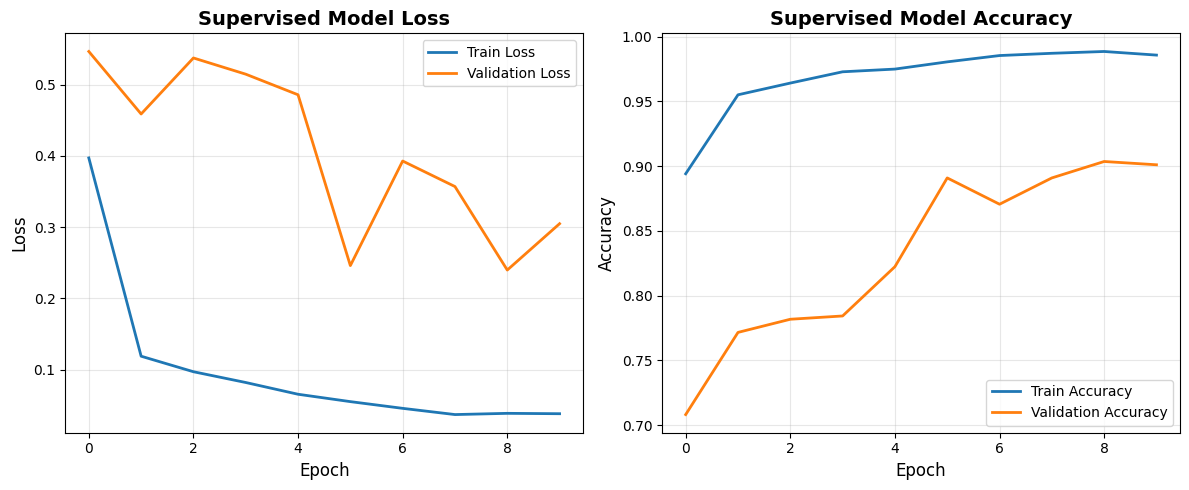


 Supervised model saved: tumor_classifier_vgg16.keras
 Final validation accuracy: 0.9010

SECTION 2: UNSUPERVISED AUTOENCODER FOR ANOMALY DETECTION
Found 395 images belonging to 1 classes.

 Healthy training samples: 395


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 38, 38, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 76, 76, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 76, 76, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 76, 76, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 152, 152, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2D)                 │ (None, 150, 150, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,747 (1.28 MB)

 Trainable params: 334,851 (1.28 MB)

 Non-trainable params: 896 (3.50 KB)


 Training autoencoder on healthy images only...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 525ms/step - loss: 0.0716 - mae: 0.2076 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 493ms/step - loss: 0.0294 - mae: 0.1261 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - loss: 0.0216 - mae: 0.1033 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - loss: 0.0226 - mae: 0.1000 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - loss: 0.0193 - mae: 0.0927 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - loss: 0.0167 - mae: 0.0885 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - loss: 0.0147 - mae: 0.0823 - learning_rate: 0.0010
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step - loss: 0.0118 - mae: 0.0733 - learning_rate: 0.0010
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - loss: 0.0117 - mae: 0.0742 - learning_rate: 0.0010
Epoch

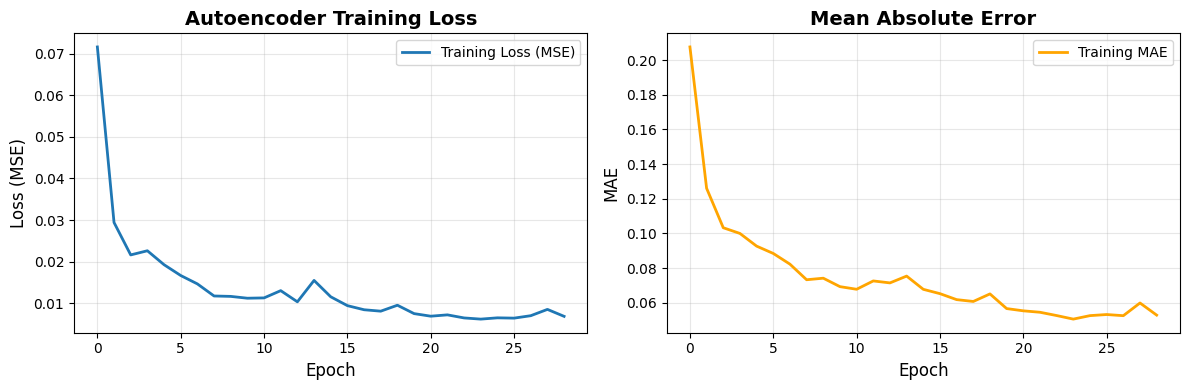


✅ Final training loss: 0.006886


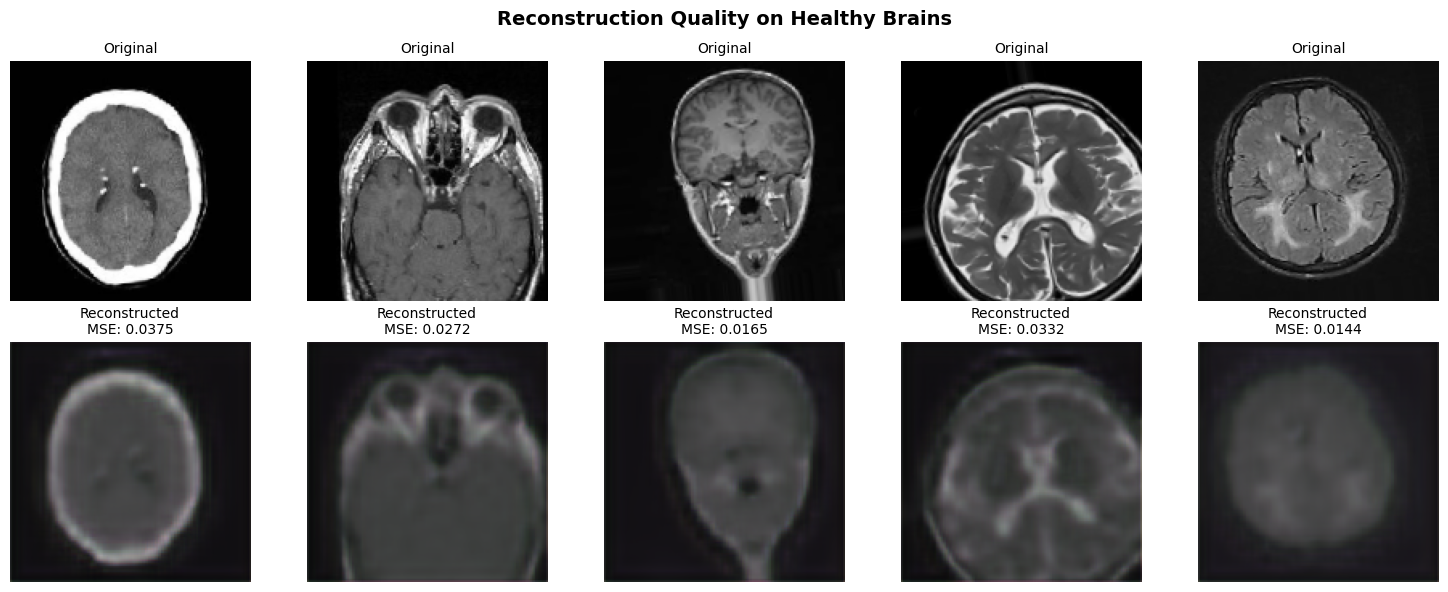


 Calculating optimal threshold...

 Reconstruction Error Statistics (healthy images):
   Mean: 0.023468
   Std:  0.013156
   95th percentile: 0.048340
   99th percentile: 0.062104

 Threshold saved: 0.048340


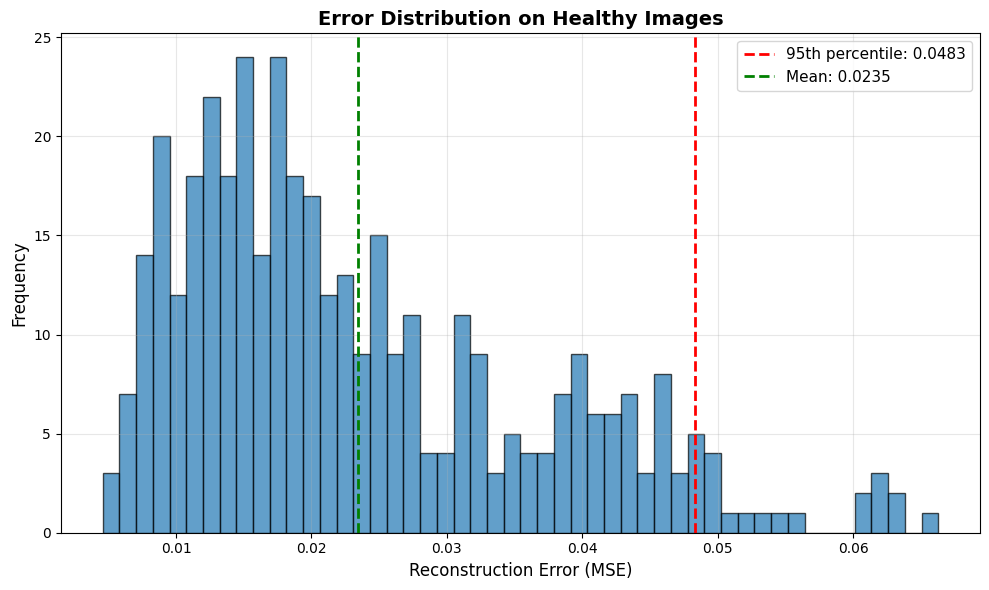


 Autoencoder saved: autoencoder_abnormality.keras

 TRAINING COMPLETE!

Models created:
  1. tumor_classifier_vgg16.keras (Supervised)
  2. autoencoder_abnormality.keras (Unsupervised)
  3. anomaly_threshold.npy (Threshold for detection)

 Next step: Run 03_evaluation.ipynb


In [1]:
# ============================================
# BRAIN TUMOR CLASSIFICATION & ANOMALY DETECTION
# 02_model_training.ipynb
# ============================================

# Part 1: SUPERVISED LEARNING (VGG16)
# Binary Classification: Tumor vs No Tumor
# ============================================

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("=" * 60)
print("SECTION 1: SUPERVISED CNN WITH TRANSFER LEARNING")
print("=" * 60)

# Create models directory
os.makedirs("../models", exist_ok=True)

# Load data
train_dir = "../data/Training"
test_dir = "../data/Testing"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(f"\n Training samples: {train_data.samples}")
print(f" Test samples: {test_data.samples}")
print(f" Classes: {train_data.class_indices}")

# Load pretrained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

# Add custom layers
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
], name='Tumor_Classifier')

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
print("\n Training supervised classifier...")
history = model.fit(
    train_data, 
    validation_data=test_data, 
    epochs=10,
    verbose=1
)

# Plot loss over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Supervised Model Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Supervised Model Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/supervised_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
model.save("../models/tumor_classifier_vgg16.keras")
print("\n Supervised model saved: tumor_classifier_vgg16.keras")
print(f" Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

# ============================================
# SECTION 2: UNSUPERVISED LEARNING (AUTOENCODER)
# Anomaly Detection: Trained only on healthy images
# ============================================

print("\n" + "=" * 60)
print("SECTION 2: UNSUPERVISED AUTOENCODER FOR ANOMALY DETECTION")
print("=" * 60)

# Data augmentation for autoencoder
train_datagen_ae = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load ONLY healthy images (no_tumor) for unsupervised learning
train_data_healthy = train_datagen_ae.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='input',  # Autoencoder: output = input
    classes=['no_tumor'],  # ONLY healthy brains!
    shuffle=True
)

print(f"\n Healthy training samples: {train_data_healthy.samples}")

# Build Convolutional Autoencoder
def build_autoencoder(input_shape=(150, 150, 3)):
    """Convolutional Autoencoder for image reconstruction"""
    
    input_img = layers.Input(shape=input_shape, name='input')
    
    # ENCODER
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 75x75
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 37x37
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # 19x19
    
    # DECODER
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)  # 38x38
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)  # 76x76
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)  # 152x152
    
    # Crop to 150x150 and reconstruct RGB
    x = layers.Cropping2D(cropping=((1, 1), (1, 1)))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output')(x)
    
    return models.Model(input_img, decoded, name='Autoencoder')

# Build and compile
autoencoder = build_autoencoder()
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

autoencoder.summary()

# Callbacks
callbacks_ae = [
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

# Train autoencoder
print("\n Training autoencoder on healthy images only...")
history_ae = autoencoder.fit(
    train_data_healthy,
    epochs=50,
    steps_per_epoch=len(train_data_healthy),
    callbacks=callbacks_ae,
    verbose=1
)

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_ae.history['loss'], label='Training Loss (MSE)', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Autoencoder Training Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_ae.history['mae'], label='Training MAE', linewidth=2, color='orange')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Mean Absolute Error', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/autoencoder_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Final training loss: {history_ae.history['loss'][-1]:.6f}")

# Test reconstruction quality
train_data_healthy.reset()
sample_images, _ = next(train_data_healthy)
reconstructed = autoencoder.predict(sample_images[:5], verbose=0)

plt.figure(figsize=(15, 6))
for i in range(5):
    # Original
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Original', fontsize=10)
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed[i])
    error = np.mean(np.square(sample_images[i] - reconstructed[i]))
    plt.title(f'Reconstructed\nMSE: {error:.4f}', fontsize=10)
    plt.axis('off')

plt.suptitle('Reconstruction Quality on Healthy Brains', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../models/reconstruction_samples.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate threshold for anomaly detection
print("\n Calculating optimal threshold...")

train_data_healthy.reset()
all_healthy = []
for i in range(len(train_data_healthy)):
    batch, _ = next(train_data_healthy)
    all_healthy.append(batch)
all_healthy = np.concatenate(all_healthy)

reconstructed_healthy = autoencoder.predict(all_healthy, verbose=0)
errors_healthy = np.mean(np.square(all_healthy - reconstructed_healthy), axis=(1, 2, 3))

mean_error = np.mean(errors_healthy)
std_error = np.std(errors_healthy)
threshold_95 = np.percentile(errors_healthy, 95)
threshold_99 = np.percentile(errors_healthy, 99)

print(f"\n Reconstruction Error Statistics (healthy images):")
print(f"   Mean: {mean_error:.6f}")
print(f"   Std:  {std_error:.6f}")
print(f"   95th percentile: {threshold_95:.6f}")
print(f"   99th percentile: {threshold_99:.6f}")

# Save threshold
np.save('../models/anomaly_threshold.npy', threshold_95)
print(f"\n Threshold saved: {threshold_95:.6f}")

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors_healthy, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(threshold_95, color='red', linestyle='--', linewidth=2, 
            label=f'95th percentile: {threshold_95:.4f}')
plt.axvline(mean_error, color='green', linestyle='--', linewidth=2, 
            label=f'Mean: {mean_error:.4f}')
plt.xlabel('Reconstruction Error (MSE)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Error Distribution on Healthy Images', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../models/error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Save autoencoder
autoencoder.save("../models/autoencoder_abnormality.keras")
print("\n Autoencoder saved: autoencoder_abnormality.keras")

print("\n" + "=" * 60)
print(" TRAINING COMPLETE!")
print("=" * 60)
print("\nModels created:")
print("  1. tumor_classifier_vgg16.keras (Supervised)")
print("  2. autoencoder_abnormality.keras (Unsupervised)")
print("  3. anomaly_threshold.npy (Threshold for detection)")
print("\n Next step: Run 03_evaluation.ipynb")